In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV    #Additional scklearn functions

from sklearn import metrics

#from sklearn import ensemble

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

In [2]:


# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [177]:
df.cntry.value_counts()

ES    2292
SE    1726
CH    1475
NO    1420
CZ    1207
DE      27
Name: cntry, dtype: int64

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [4]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

### Evaluation of Model - Confusion Matrix Plot

based on the example here:

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [5]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


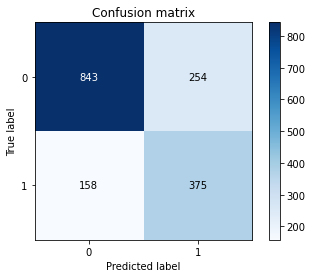

In [6]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


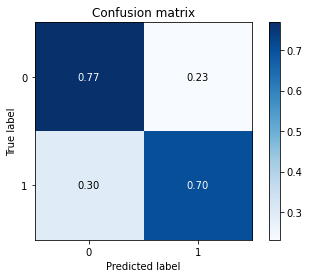

In [7]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm,[0,1],True)

### Accuracy

In [8]:
clf.score(X_test, y_test)

0.747239263803681

### Precision

In [9]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred)

0.7035647279549718

### Recall

In [10]:
recall_score(y_test,y_pred)

0.5961844197138315

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

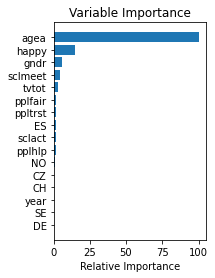

In [11]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, but there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

You can learn more about the parameters for the gradient boost model [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and update the **params** table featured earlier, before we initialized and fit the model.

A few parameters to tune could be:
 - learning_rate
 - max_depth
 - n_estimators
 - loss
 - subsample
 - min_samples_split
 
You can then use the same metrics to evaluate your results.
          
Have fun!

### Challenge

In [174]:
df_2 = df.copy()
df_2.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [175]:
df_2['partner'].describe()

count    8147.000000
mean        1.384681
std         0.486550
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: partner, dtype: float64

In [176]:
df_2['partner'] = df_2['partner'] - 1

In [177]:
df.cntry.value_counts()

ES    2292
SE    1726
CH    1475
NO    1420
CZ    1207
DE      27
Name: cntry, dtype: int64

In [178]:
# drops countries that are not listed many times
vc = df.cntry.value_counts()
u  = [i in set(vc[vc > 1000].index) for i in df_2.cntry]
df_2 = df_2[u]
df_2.cntry.value_counts()

ES    2292
SE    1726
CH    1475
NO    1420
CZ    1207
Name: cntry, dtype: int64

In [179]:
df_2 = pd.concat([df_2, pd.get_dummies(df_2['cntry'])], axis=1)

In [180]:
df_2 = df_2.drop('cntry', axis = 1)
df_2.head()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,CH,CZ,ES,NO,SE
0,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0.0,1,0,0,0,0
1,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0.0,1,0,0,0,0
2,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1.0,1,0,0,0,0
3,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0.0,1,0,0,0,0
4,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0.0,1,0,0,0,0


In [357]:
df_2.shape

(8115, 17)

In [181]:
df_2.describe()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,CH,CZ,ES,NO,SE
count,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.000000,8120.00000,8120.000000,8120.000000,8120.000000,8120.000000
mean,3781.991133,6.500246,3.818103,5.576108,6.004433,5.321059,7.708867,5.217734,2.755788,1.496059,47.229926,0.385099,0.18165,0.148645,0.282266,0.174877,0.212562
std,5277.319956,0.500031,2.008000,2.216260,2.120866,2.166888,1.721665,1.439893,0.901527,0.500015,18.318250,0.486649,0.38558,0.355760,0.450130,0.379885,0.409145
min,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1062.000000,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1743.000000,7.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,2768.000000,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000
max,22428.000000,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


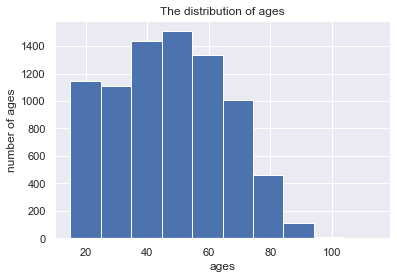

In [182]:
plt.hist(df_2.agea)
plt.title("The distribution of ages")
plt.xlabel("ages")
plt.ylabel("number of ages")
plt.show()

In [183]:
df_2.agea.value_counts().sort_values()

97.0       1
96.0       1
114.0      1
103.0      1
101.0      1
        ... 
39.0     154
48.0     155
42.0     159
46.0     166
54.0     167
Name: agea, Length: 83, dtype: int64

In [184]:
# drops countries that are not listed many times
vc = df.agea.value_counts()
u  = [i in set(vc[vc > 1].index) for i in df_2.agea]
df_2 = df_2[u]
df_2.agea.value_counts()

54.0    167
46.0    166
42.0    159
48.0    155
39.0    154
       ... 
91.0      7
92.0      6
93.0      5
95.0      2
94.0      2
Name: agea, Length: 78, dtype: int64

In [185]:
df_2.head()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,CH,CZ,ES,NO,SE
0,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0.0,1,0,0,0,0
1,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0.0,1,0,0,0,0
2,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1.0,1,0,0,0,0
3,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0.0,1,0,0,0,0
4,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0.0,1,0,0,0,0


In [412]:
df_2.groupby('partner')['happy'].count()

partner
0.0    4993
1.0    3122
Name: happy, dtype: int64

### Framing up model data

In [187]:
scaler = MinMaxScaler()
for col in df_2.loc[:, ~df_2.columns.isin(['idno'])]:
    df_2[col] = scaler.fit_transform(df_2[[col]])

In [189]:
df_2.describe()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,CH,CZ,ES,NO,SE
count,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000
mean,3783.730376,0.500308,0.545533,0.557597,0.600456,0.532076,0.770893,0.702855,0.439094,0.495995,0.402451,0.384720,0.181762,0.148737,0.282070,0.174985,0.212446
std,5278.454185,0.500031,0.286797,0.221630,0.212097,0.216676,0.172143,0.240002,0.225325,0.500015,0.228404,0.486559,0.385672,0.355851,0.450035,0.379977,0.409064
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1062.000000,0.000000,0.285714,0.400000,0.500000,0.400000,0.700000,0.500000,0.250000,0.000000,0.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1744.000000,1.000000,0.571429,0.600000,0.600000,0.500000,0.800000,0.833333,0.500000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2769.000000,1.000000,0.714286,0.700000,0.800000,0.700000,0.900000,0.833333,0.500000,1.000000,0.575000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,22428.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [190]:
target = df_2['partner']

predictors = [x for x in df_2.columns if x not in ['partner', 'idno']]
#predictors = scaler.fit_transform(df_2[predictors])

In [191]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['partner'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['partner'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['partner'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['partner'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7733
AUC Score (Train): 0.821238
CV Score : Mean - 0.789227 | Std - 0.01638183 | Min - 0.7630924 | Max - 0.8129147


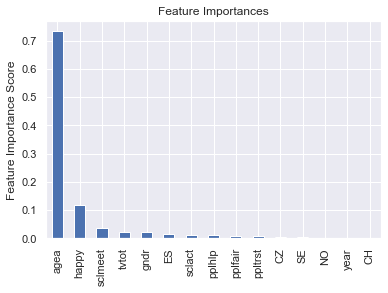

In [192]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, df_2, predictors)

### Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

- min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
- min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
- max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
- max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
- subsample = 0.8 : This is a commonly used used start value


Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.

In [193]:
#Choose all predictors except target & IDcols
#target = df_2['partner']

#predictors = [x for x in df_2.columns if x not in ['partner', 'idno']]

param_test1 = {'n_estimators':range(50,500,50)}

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(df_2[predictors],df_2['partner'])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(50, 500, 50)},
             scoring='roc_auc')

In [194]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.30757771, 0.59979544, 0.95165515, 1.32625394, 1.58117228,
         1.76946979, 2.14785838, 2.50609984, 2.49952736]),
  'std_fit_time': array([0.00486978, 0.00606924, 0.06470659, 0.01607404, 0.07136261,
         0.00938492, 0.11872279, 0.13551316, 0.17364792]),
  'mean_score_time': array([0.00877852, 0.01196833, 0.01515951, 0.01894917, 0.02034712,
         0.0241353 , 0.02732697, 0.03111796, 0.03132186]),
  'std_score_time': array([0.00074609, 0.00109249, 0.00146554, 0.00089239, 0.00101829,
         0.00116333, 0.00149232, 0.00298444, 0.00381713]),
  'param_n_estimators': masked_array(data=[50, 100, 150, 200, 250, 300, 350, 400, 450],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 50},
   {'n_estimators': 100},
   {'n_estimators': 150},
   {'n_estimators': 200},
   {'n_estimators': 250},
   {'n_estimators': 300},
   {'

As you can see that here we got 80 as the optimal estimators for 0.1 learning rate. Note that 80 is a reasonable value and can be used as it is. But it might not be the same in all cases. Other situations:

- If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search
- If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate
 

### Tuning tree-specific parameters
Now lets move onto tuning the tree parameters. I plan to do this in following stages:

- Tune max_depth and num_samples_split
- Tune min_samples_leaf
- Tune max_features


The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

To start with, I’ll test max_depth values of 2 to 15 in steps of 2 and min_samples_split from 200 to 1000 in steps of 200. These are just based on my intuition. You can set wider ranges as well and then perform multiple iterations for smaller ranges.

In [195]:
param_test2 = {'max_depth':range(2,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_2[predictors],df_2['partner'])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.37519565, 0.35983915, 0.34906602, 0.32532973, 0.3305161 ,
         0.51123276, 0.48490276, 0.43443894, 0.42326946, 0.41509008,
         0.60218987, 0.55571156, 0.54255013, 0.50185981, 0.48869448,
         0.74341197, 0.65325432, 0.59121938, 0.55710993, 0.52898526,
         0.85052586, 0.70670986, 0.62133832, 0.57007537, 0.53377376,
         0.97958045, 0.82399459, 0.66183028, 0.5876276 , 0.59780087,
         1.09766479, 0.87406254, 0.69813409, 0.58722911, 0.5150219 ]),
  'std_fit_time': array([0.0188958 , 0.03099424, 0.01759515, 0.00662729, 0.01585297,
         0.01382903, 0.03112184, 0.00411685, 0.0052246 , 0.00616043,
         0.00586274, 0.00330153, 0.00862568, 0.00592938, 0.00574638,
         0.01039539, 0.00898734, 0.00622514, 0.00966127, 0.00761132,
         0.01644105, 0.01165846, 0.00944076, 0.00645237, 0.0058643 ,
         0.01717584, 0.04524901, 0.0384965 , 0.01559766, 0.02495813,
         0.05736014, 0.03178751, 0.02501655, 0.01019899, 0.0295427 ]

Here, we have run 30 combinations and the ideal values are 7 for max_depth and 400 for min_samples_split. Note that, 1000 is an extreme value which we tested. There is a fare chance that the optimum value lies above that. So we should check for some higher values as well.

Here, I’ll take the max_depth of 8 as optimum and not try different values for higher min_samples_split. It might not be the best idea always but here if you observe the output closely, max_depth of 8 works better in most of the cases. Also, we can test for 5 values of min_samples_leaf, from 30 to 70 in steps of 10, along with higher min_samples_split.

In [362]:
param_test3 = {'min_samples_split':range(400,1600,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=8,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_2[predictors],df_2['partner'])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.94208169, 0.83835826, 0.80305271, 0.68596959, 0.66602092,
         0.67280126, 0.88144331, 0.78948903, 0.75857301, 0.70511622,
         0.71867752, 0.69434299, 0.88303752, 0.79507422, 0.74121876,
         0.72007494, 0.81362624, 0.62273698, 0.85152159, 0.76475673,
         0.71768203, 0.68397064, 0.67459478, 0.62931719, 0.84334579,
         0.84114981, 0.82040677, 0.76635003, 0.73264089, 0.63171115]),
  'std_fit_time': array([0.0246368 , 0.05738414, 0.05074894, 0.0264436 , 0.01288687,
         0.03432774, 0.03171153, 0.02514922, 0.01584001, 0.03916604,
         0.05655685, 0.02175332, 0.01969055, 0.0194657 , 0.04175674,
         0.03211236, 0.07391369, 0.01529161, 0.02938   , 0.01008034,
         0.0314724 , 0.04730073, 0.02620917, 0.01327597, 0.03780186,
         0.04306289, 0.03163643, 0.0298909 , 0.04053002, 0.06861319]),
  'mean_score_time': array([0.01934805, 0.01735368, 0.01655521, 0.02054105, 0.01176696,
         0.01196742, 0.01974702, 0.01934819, 0.

Here we get the optimum values as 400 for min_samples_split and 30 for min_samples_leaf. Also, we can see the CV score decreasing to 0.7873 now. Let’s fit the model again on this and have a look at the feature importance.


Model Report
Accuracy : 0.788
AUC Score (Train): 0.854455
CV Score : Mean - 0.7873043 | Std - 0.0170426 | Min - 0.7579198 | Max - 0.8107322


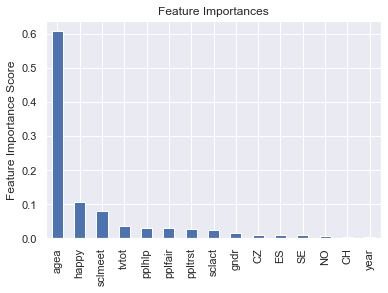

In [363]:
modelfit(gsearch3.best_estimator_, df_2, predictors)

If you compare the feature importance of this model with the baseline model, you’ll find that now we are able to derive value from many more variables. It is still placing a lot of importance on age, but less so than previous models.

Now lets tune the last tree-parameters, i.e. max_features by trying 8 values from 2 to 16 in steps of 2.

In [364]:
param_test4 = {'max_features':range(2,16,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=8, min_samples_split=400, min_samples_leaf=30, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_2[predictors],df_2['partner'])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.80604591, 1.08070812, 1.20458059, 1.39626532, 1.59214325,
         1.73875179, 1.79420371]),
  'std_fit_time': array([0.04432635, 0.04230198, 0.07260563, 0.03078371, 0.04106171,
         0.02148006, 0.11017865]),
  'mean_score_time': array([0.01795168, 0.01855512, 0.01356354, 0.0155581 , 0.01376419,
         0.01715469, 0.01317158]),
  'std_score_time': array([0.0056418 , 0.01084641, 0.00279328, 0.0023254 , 0.00159506,
         0.0084252 , 0.00262265]),
  'param_max_features': masked_array(data=[2, 4, 6, 8, 10, 12, 14],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 2},
   {'max_features': 4},
   {'max_features': 6},
   {'max_features': 8},
   {'max_features': 10},
   {'max_features': 12},
   {'max_features': 14}],
  'split0_test_score': array([0.80997343, 0.80995098, 0.81079958, 0.81620402, 0.80910237,
         0.80824575, 0.8081495 ]),
  'split1_test

Here, we find that optimum value is 4, which is also the square root. So our initial value was the best.You might be anxious to check for lower values and you should if you like. I’ll stay with 6 for now. With this we have the final tree-parameters as:

- min_samples_split: 400
- min_samples_leaf: 30
- max_depth: 8
- max_features: 6

### Tuning subsample and making models with lower learning rate

The next step would be try different subsample values. Lets take values 0.6,0.7,0.75,0.8,0.85,0.9.

In [365]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=8,min_samples_split=400, min_samples_leaf=30, subsample=0.8, random_state=10,max_features=6),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(df_2[predictors],df_2['partner'])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([1.04680161, 1.14214768, 1.22452493, 1.17725306, 1.2003911 ,
         1.10424814]),
  'std_fit_time': array([0.02564138, 0.02914241, 0.01778869, 0.04493752, 0.03553979,
         0.15052726]),
  'mean_score_time': array([0.02074461, 0.01356273, 0.02513361, 0.01835089, 0.01575799,
         0.0141623 ]),
  'std_score_time': array([0.00994209, 0.00135354, 0.00998192, 0.00747984, 0.0052168 ,
         0.00291795]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([0.81277752, 0.81008252, 0.81237808, 0.81079958, 0.80979858,
         0.81250481]),
  'split1_test_score': array([0.75498977, 0.75540765, 0.7530006 , 0.75149188, 0.75318909,
         0.752031

Here, we found 0.70 as the optimum value, which was the default. Finally, we have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. Note that these trees might not be the most optimum values but a good benchmark.

As trees increase, it will become increasingly computationally expensive to perform CV and find the optimum values. For you to get some idea of the model performance, I have included the private leaderboard scores for each. Since the data is not open, you won’t be able to replicate that but it’ll good for understanding.

Lets decrease the learning rate to half, i.e. 0.05 with twice (100) the number of trees.


Model Report
Accuracy : 0.7779
AUC Score (Train): 0.836156
CV Score : Mean - 0.787618 | Std - 0.01966638 | Min - 0.7538717 | Max - 0.8139806


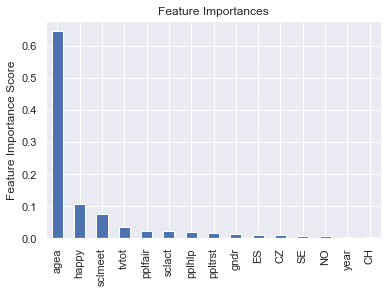

In [366]:
#predictors = [x for x in df_2.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=8, min_samples_split=400,min_samples_leaf=30, subsample=0.70, random_state=10, max_features=6)
modelfit(gbm_tuned_1,df_2, predictors)

Now lets reduce to one-tenth of the original value, i.e. 0.01 for 600 trees.


Model Report
Accuracy : 0.7436
AUC Score (Train): 0.802128
CV Score : Mean - 0.7814746 | Std - 0.01863061 | Min - 0.7478207 | Max - 0.8015451


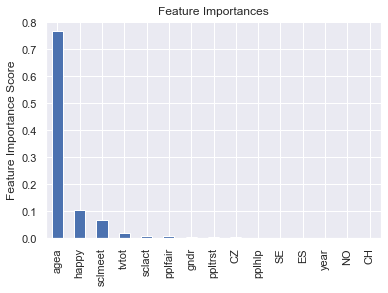

In [378]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100,max_depth=8, min_samples_split=700,min_samples_leaf=30, subsample=0.70, random_state=10, max_features=6)
modelfit(gbm_tuned_2,df_2, predictors)

### Try model with new parameters on Thinkful style

In [379]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df_2['partner']
X = df_2.loc[:, ~df_2.columns.isin(['partner', 'idno'])]

In [380]:
# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [402]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

#params = {'n_estimators': 500,
         # 'max_depth': 2,
         # 'loss': 'deviance'}

# Initialize and fit the model.
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=8, min_samples_split=400,min_samples_leaf=30, subsample=0.70, random_state=10, max_features=6)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

### Evaluation of Model - Confusion Matrix Plot

based on the example here:

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [403]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


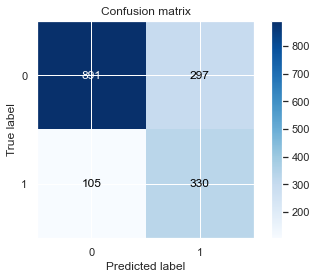

In [404]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


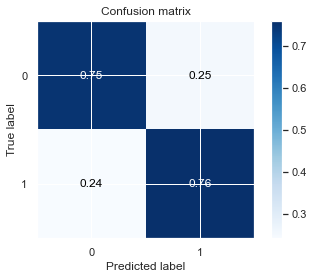

In [405]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm,[0,1],True)

### Accuracy

In [406]:
clf.score(X_test, y_test)

0.7523105360443623

### Precision

In [407]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred)

0.7586206896551724

### Recall

In [408]:
recall_score(y_test,y_pred)

0.5263157894736842

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

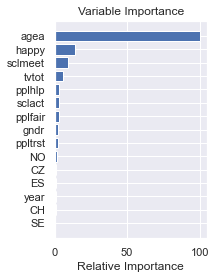

In [409]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [12]:
df_2 = df.copy()
df_2.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [13]:
# Count how many nulls there are per column
total_nulls = df_2.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)

total nulls per column
partner    0
agea       0
gndr       0
sclact     0
sclmeet    0
happy      0
pplhlp     0
pplfair    0
ppltrst    0
tvtot      0
year       0
idno       0
cntry      0
dtype: int64


In [14]:
df_2['partner'].describe()

count    8147.000000
mean        1.384681
std         0.486550
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: partner, dtype: float64

In [15]:
df_2['partner'] = df_2['partner'] - 1

In [16]:
df_2.sample(10)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
5959,NO,20352.0,6,2.0,3.0,4.0,2.0,9.0,6.0,4.0,2.0,44.0,0.0
346,CH,1264.0,6,3.0,8.0,8.0,7.0,8.0,7.0,3.0,1.0,16.0,1.0
4962,ES,2074.0,7,3.0,4.0,6.0,4.0,8.0,5.0,3.0,1.0,80.0,0.0
6166,NO,8724.0,7,5.0,5.0,0.0,6.0,8.0,5.0,3.0,1.0,33.0,1.0
4727,ES,1495.0,7,5.0,5.0,6.0,4.0,8.0,6.0,4.0,2.0,27.0,0.0
8155,SE,1663.0,7,4.0,8.0,8.0,7.0,5.0,3.0,2.0,2.0,50.0,0.0
7803,SE,475.0,7,7.0,5.0,7.0,5.0,9.0,6.0,3.0,1.0,73.0,0.0
118,CH,539.0,6,6.0,6.0,5.0,6.0,9.0,6.0,3.0,1.0,46.0,0.0
2476,CZ,1277.0,7,0.0,8.0,7.0,7.0,10.0,6.0,3.0,2.0,31.0,0.0
6360,NO,13218.0,7,2.0,8.0,7.0,7.0,6.0,7.0,3.0,2.0,23.0,0.0


In [17]:
df_2.describe(include = 'all')

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
count,8147,8.147000e+03,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.022622e+04,6.500307,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,1.496379,47.262182,0.384681
std,NaN,6.320721e+05,0.500031,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,0.500018,18.316890,0.486550
min,NaN,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000
25%,NaN,1.063000e+03,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,0.000000
50%,NaN,1.749000e+03,7.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,0.000000
75%,NaN,2.778000e+03,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,1.000000


In [18]:
df_2 = pd.concat([df_2, pd.get_dummies(df_2['cntry'])], axis=1)

In [19]:
df_2 = df_2.drop('cntry', axis = 1)
df_2.head()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,CH,CZ,DE,ES,NO,SE
0,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0.0,1,0,0,0,0,0
1,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0.0,1,0,0,0,0,0
2,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1.0,1,0,0,0,0,0
3,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0.0,1,0,0,0,0,0
4,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0.0,1,0,0,0,0,0


In [24]:
X

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,7,3.0,4.0,5.0,3.0,6.0,6.0,2.0,1.0,18.0,0,0,0,0,0,1
8590,7,5.0,6.0,4.0,4.0,10.0,6.0,3.0,1.0,15.0,0,0,0,0,0,1
8591,7,4.0,5.0,7.0,6.0,8.0,6.0,3.0,1.0,44.0,0,0,0,0,0,1
8592,7,5.0,8.0,8.0,6.0,9.0,7.0,3.0,1.0,15.0,0,0,0,0,0,1


In [23]:
data = {X.columns: feature_importance}

TypeError: unhashable type: 'Index'

In [20]:
feature_importance_df = pd.DataFrame({'importance' :  X.columns, 'feature_value' : feature_importance})

In [21]:
feature_importance_df.head(20)

,importance,feature_value
0,year,0.319153
1,tvtot,3.120552
2,ppltrst,1.721511
3,pplfair,1.893393
4,pplhlp,1.561429
5,happy,14.752639
6,sclmeet,4.144111
7,sclact,1.637819
8,gndr,5.534195
9,agea,100.000000


In [22]:
to_drop = feature_importance_df[feature_importance_df['feature_value'] < 1].index
print(to_drop)

Int64Index([0, 10, 11, 12, 14, 15], dtype='int64')


In [ ]:
lower_corr_df = pd.DataFrame(correlation_cat)

lower_corr_df.columns = ['correlation_cat']

# correlation df
lower_corr_df = lower_corr_df.copy()

lower_corr_df = lower_corr_df.drop(['Id','SalePrice'])

### New Model

In [48]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df_2['partner']
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [49]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=learning_rate, max_features=3, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.764
Accuracy score (validation): 0.752
Learning rate:  0.075
Accuracy score (training): 0.770
Accuracy score (validation): 0.753
Learning rate:  0.1
Accuracy score (training): 0.774
Accuracy score (validation): 0.755
Learning rate:  0.25
Accuracy score (training): 0.788
Accuracy score (validation): 0.750
Learning rate:  0.5
Accuracy score (training): 0.800
Accuracy score (validation): 0.748
Learning rate:  0.75
Accuracy score (training): 0.810
Accuracy score (validation): 0.744
Learning rate:  1
Accuracy score (training): 0.817
Accuracy score (validation): 0.726


In [127]:
gb_clf2 = ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=.1, max_features=3, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predict_train = gb_clf2.predict(X_train)
predict_test = gb_clf2.predict(X_test)

In [128]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


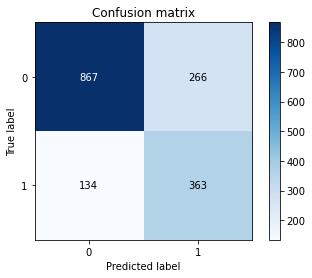

In [129]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


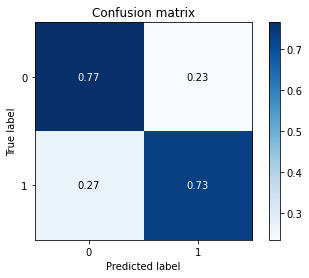

In [130]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm,[0,1],True)

### Accuracy

In [131]:
gb_clf2.score(X_test, y_test)

0.754601226993865

### Precision

In [132]:
y_pred = gb_clf2.predict(X_test)
precision_score(y_test,y_pred)

0.7303822937625755

### Recall

In [133]:
recall_score(y_test,y_pred)

0.5771065182829889

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

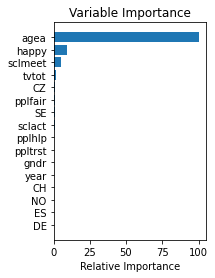

In [134]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Accuracy of the model is overall not much better after tuning parameters. Could be a feature issue. Not knowing what each feature really means due to a lack of explanation by Thinkful could result in garbage input and ruin the model further.